# Coding: Language Model based on LSTM

 - Dataset: WikiText-2
 - Model: LSTM/GRU
 - Optimizer: Adam
 - Learning Rate: 0.001
 - Batch Size: 64
 - Epochs: 10
 - Dropout: 0.2

In [3]:
# Load WikiText-2 Dataset using Hugging Face datasets

import torch
from datasets import load_dataset
from torch.utils.data import DataLoader
from collections import Counter
import re

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Load WikiText-2 dataset from Hugging Face
print("Loading WikiText-2 dataset from Hugging Face...")
dataset = load_dataset("wikitext", "wikitext-2-v1")

# Access the splits
train_dataset = dataset['train']
val_dataset = dataset['validation']
test_dataset = dataset['test']

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

# Show a sample
# Find a non-empty sample
print(f"\nLooking for non-empty samples...")
sample_text = None
for i, example in enumerate(train_dataset):
    if example['text'].strip():  # Find first non-empty line
        sample_text = example['text']
        print(f"Found non-empty sample at index {i}")
        break
print(f"First sample: {sample_text[:200]}")

# Basic tokenization function
def basic_tokenize(text):
    # Convert to lowercase and split on whitespace and punctuation
    text = text.lower()
    tokens = re.findall(r'\b\w+\b', text)
    return tokens

# Build vocabulary from training data
print("\nBuilding vocabulary...")
all_tokens = []
non_empty_lines = 0
for example in train_dataset:
    if example['text'].strip():  # Skip empty lines
        tokens = basic_tokenize(example['text'])
        all_tokens.extend(tokens)
        non_empty_lines += 1

# Create vocabulary
vocab_counter = Counter(all_tokens)
vocab_size = len(vocab_counter)
print(f"Non-empty lines: {non_empty_lines}")
print(f"Total tokens: {len(all_tokens)}")
print(f"Vocabulary size: {vocab_size}")

# Create word to index mapping
vocab = {'<unk>': 0, '<pad>': 1}
for word, count in vocab_counter.most_common():
    if word not in vocab:
        vocab[word] = len(vocab)

# Create index to word mapping
idx_to_word = {idx: word for word, idx in vocab.items()}

print(f"Final vocabulary size (with special tokens): {len(vocab)}")
print(f"Most common words: {list(vocab_counter.most_common(10))}")

# Function to convert text to indices
def text_to_indices(text, vocab):
    tokens = basic_tokenize(text)
    return [vocab.get(token, vocab['<unk>']) for token in tokens]

# Convert a sample to see the tokenization
sample_indices = text_to_indices(sample_text, vocab)
print(f"\nSample tokenization:")
print(f"Original: {sample_text[:100]}")
print(f"Tokens: {basic_tokenize(sample_text)[:20]}")
print(f"Indices: {sample_indices[:20]}")

print("\nDataset loaded successfully!")

Using device: cuda
Loading WikiText-2 dataset from Hugging Face...


README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/685k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/6.07M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/618k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

Train dataset size: 36718
Validation dataset size: 3760
Test dataset size: 4358

Looking for non-empty samples...
Found non-empty sample at index 1
First sample:  = Valkyria Chronicles III = 


Building vocabulary...
Non-empty lines: 23767
Total tokens: 1750345
Vocabulary size: 28710
Final vocabulary size (with special tokens): 28712
Most common words: [('the', 130768), ('of', 57030), ('unk', 54625), ('and', 50735), ('in', 45015), ('to', 39521), ('a', 36523), ('was', 21008), ('on', 15140), ('as', 15058)]

Sample tokenization:
Original:  = Valkyria Chronicles III = 

Tokens: ['valkyria', 'chronicles', 'iii']
Indices: [3767, 3830, 860]

Dataset loaded successfully!


In [4]:
# Data Preprocess & Init DataLoader

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

class WikiTextDataset(Dataset):
    def __init__(self, hf_dataset, vocab, sequence_length=50):
        """
        Custom Dataset for WikiText-2
        
        Args:
            hf_dataset: Hugging Face dataset split
            vocab: vocabulary dictionary
            sequence_length: length of input sequences
        """
        self.vocab = vocab
        self.sequence_length = sequence_length
        
        # Process all text and create sequences
        self.sequences = []
        self.targets = []
        
        print(f"Processing dataset with sequence length: {sequence_length}")
        
        # Concatenate all non-empty text and tokenize
        all_indices = []
        for example in hf_dataset:
            if example['text'].strip():  # Skip empty lines
                indices = text_to_indices(example['text'], vocab)
                all_indices.extend(indices)
        
        print(f"Total tokens in dataset: {len(all_indices)}")
        
        # Create sequences of specified length
        for i in range(len(all_indices) - sequence_length):
            # Input sequence
            seq = all_indices[i:i + sequence_length]
            # Target is the next token
            target = all_indices[i + sequence_length]
            
            self.sequences.append(seq)
            self.targets.append(target)
        
        print(f"Created {len(self.sequences)} sequences")
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return (
            torch.tensor(self.sequences[idx], dtype=torch.long),
            torch.tensor(self.targets[idx], dtype=torch.long)
        )

# Create datasets
sequence_length = 50
batch_size = 64

print("Creating training dataset...")
train_wiki_dataset = WikiTextDataset(train_dataset, vocab, sequence_length)

print("\nCreating validation dataset...")
val_wiki_dataset = WikiTextDataset(val_dataset, vocab, sequence_length)

print("\nCreating test dataset...")
test_wiki_dataset = WikiTextDataset(test_dataset, vocab, sequence_length)

# Create DataLoaders
train_loader = DataLoader(
    train_wiki_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=0  # Set to 0 for compatibility
)

val_loader = DataLoader(
    val_wiki_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=0
)

test_loader = DataLoader(
    test_wiki_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=0
)

print(f"\nDataLoader Summary:")
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")
print(f"Batch size: {batch_size}")
print(f"Sequence length: {sequence_length}")

# Test the DataLoader
print("\nTesting DataLoader...")
for batch_idx, (sequences, targets) in enumerate(train_loader):
    print(f"Batch {batch_idx + 1}:")
    print(f"  Sequences shape: {sequences.shape}")
    print(f"  Targets shape: {targets.shape}")
    print(f"  Sample sequence: {sequences[0][:10].tolist()}")
    print(f"  Sample target: {targets[0].item()}")
    
    # Convert back to words for verification
    sample_words = [idx_to_word[idx.item()] for idx in sequences[0]]
    target_word = idx_to_word[targets[0].item()]
    print(f"  Sample words: {sample_words}")
    print(f"  Target word: {target_word}")
    break  # Only show first batch

print("\nDataLoader created successfully!")

Creating training dataset...
Processing dataset with sequence length: 50
Total tokens in dataset: 1750345
Created 1750295 sequences

Creating validation dataset...
Processing dataset with sequence length: 50
Total tokens in dataset: 183606
Created 183556 sequences

Creating test dataset...
Processing dataset with sequence length: 50
Total tokens in dataset: 206381
Created 206331 sequences

DataLoader Summary:
Training batches: 27349
Validation batches: 2869
Test batches: 3224
Batch size: 64
Sequence length: 50

Testing DataLoader...
Batch 1:
  Sequences shape: torch.Size([64, 50])
  Targets shape: torch.Size([64])
  Sample sequence: [22763, 5, 1997, 14, 307, 6, 1325, 3, 13, 78]
  Sample target: 1010
  Sample words: ['hantzopoulos', 'and', 'scheduled', 'for', 'release', 'in', 'fall', 'of', 'that', 'year', 'that', 'may', 'the', 'game', 'was', 'shown', 'at', 'the', 'electronic', 'arts', 'booth', 'at', 'e3', 'computer', 'games', 'magazine', 's', 'steve', 'udell', 'wrote', 'that', 'the', 'g

In [5]:
# GRU Language Model Implementation

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import math

class GRULanguageModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim=256, hidden_dim=512, num_layers=2, dropout=0.2):
        """
        GRU-based Language Model for next word prediction
        
        Args:
            vocab_size: Size of vocabulary
            embedding_dim: Dimension of word embeddings
            hidden_dim: Hidden dimension of GRU
            num_layers: Number of GRU layers
            dropout: Dropout probability
        """
        super(GRULanguageModel, self).__init__()
        
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.dropout = dropout
        
        # Word embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # GRU layer(s)
        self.gru = nn.GRU(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True
        )
        
        # Dropout layer
        self.dropout_layer = nn.Dropout(dropout)
        
        # Output projection layer
        self.output_projection = nn.Linear(hidden_dim, vocab_size)
        
        # Initialize weights
        self.init_weights()
    
    def init_weights(self):
        """Initialize model weights"""
        # Initialize embedding weights
        nn.init.uniform_(self.embedding.weight, -0.1, 0.1)
        
        # Initialize GRU weights
        for name, param in self.gru.named_parameters():
            if 'weight' in name:
                nn.init.orthogonal_(param)
            elif 'bias' in name:
                nn.init.zeros_(param)
        
        # Initialize output layer
        nn.init.xavier_uniform_(self.output_projection.weight)
        nn.init.zeros_(self.output_projection.bias)
    
    def forward(self, input_ids, hidden=None):
        """
        Forward pass
        
        Args:
            input_ids: Input token indices [batch_size, seq_len]
            hidden: Hidden state from previous step
            
        Returns:
            logits: Output logits [batch_size, seq_len, vocab_size]
            hidden: Final hidden state
        """
        batch_size, seq_len = input_ids.size()
        
        # Word embeddings
        embeddings = self.embedding(input_ids)  # [batch_size, seq_len, embedding_dim]
        
        # Apply dropout to embeddings
        embeddings = self.dropout_layer(embeddings)
        
        # GRU forward pass, 2 layers by default
        gru_output, hidden = self.gru(embeddings, hidden)  # [batch_size, seq_len, hidden_dim]
        
        # Apply dropout to GRU output
        gru_output = self.dropout_layer(gru_output)
        
        # Project to vocabulary size
        logits = self.output_projection(gru_output)  # [batch_size, seq_len, vocab_size]
        
        return logits, hidden
    
    def init_hidden(self, batch_size):
        """Initialize hidden state"""
        return torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(next(self.parameters()).device)

# Model hyperparameters
vocab_size = len(vocab)
embedding_dim = 64
hidden_dim = 128
num_layers = 1
dropout = 0.0
learning_rate = 0.0001

# Initialize model
model = GRULanguageModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
    num_layers=num_layers,
    dropout=dropout
)

# Move model to device
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=vocab['<pad>'])  # Ignore padding tokens
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Print model information
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nGRU Language Model Summary:")
print(f"Vocabulary size: {vocab_size:,}")
print(f"Embedding dimension: {embedding_dim}")
print(f"Hidden dimension: {hidden_dim}")
print(f"Number of layers: {num_layers}")
print(f"Dropout: {dropout}")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Model device: {next(model.parameters()).device}")

# Test the model with a sample batch
print(f"\nTesting model with sample batch...")
model.eval()
with torch.no_grad():
    # Get a sample batch
    sample_sequences, sample_targets = next(iter(train_loader))
    sample_sequences = sample_sequences.to(device)
    sample_targets = sample_targets.to(device)
    
    # Forward pass
    logits, hidden = model(sample_sequences)
    
    print(f"Input shape: {sample_sequences.shape}")
    print(f"Output logits shape: {logits.shape}")
    print(f"Hidden state shape: {hidden.shape}")
    print(f"Target shape: {sample_targets.shape}")
    
    # Calculate loss for the last token prediction
    last_token_logits = logits[:, -1, :]  # [batch_size, vocab_size]
    loss = criterion(last_token_logits, sample_targets)
    print(f"Sample loss: {loss.item():.4f}")
    
    # Get predictions
    predictions = torch.argmax(last_token_logits, dim=-1)
    accuracy = (predictions == sample_targets).float().mean()
    print(f"Sample accuracy: {accuracy.item():.4f}")

print(f"\nModel initialized successfully!")


GRU Language Model Summary:
Vocabulary size: 28,712
Embedding dimension: 64
Hidden dimension: 128
Number of layers: 1
Dropout: 0.0
Total parameters: 5,615,912
Trainable parameters: 5,615,912
Model device: cuda:0

Testing model with sample batch...
Input shape: torch.Size([64, 50])
Output logits shape: torch.Size([64, 50, 28712])
Hidden state shape: torch.Size([1, 64, 128])
Target shape: torch.Size([64])
Sample loss: 10.2648
Sample accuracy: 0.0000

Model initialized successfully!


🚀 Starting GRU Language Model Training...
Model has 5,615,912 parameters
Starting training for 10 epochs...
Training batches: 27349
Validation batches: 2869
------------------------------------------------------------


Epoch 1 Training:   4%|▎         | 1011/27349 [00:12<04:45, 92.30it/s, Loss=7.8671, Acc=0.0745]


Batch 1000/27349:
  Loss: 7.8725
  Accuracy: 0.0747


Epoch 1 Training:   7%|▋         | 2016/27349 [00:24<04:15, 99.09it/s, Loss=7.6490, Acc=0.0738]


Batch 2000/27349:
  Loss: 7.6525
  Accuracy: 0.0738


Epoch 1 Training:  11%|█         | 3013/27349 [00:34<04:23, 92.42it/s, Loss=7.5624, Acc=0.0756] 


Batch 3000/27349:
  Loss: 7.5630
  Accuracy: 0.0755


Epoch 1 Training:  15%|█▍        | 4015/27349 [00:45<04:09, 93.67it/s, Loss=7.5010, Acc=0.0781] 


Batch 4000/27349:
  Loss: 7.5026
  Accuracy: 0.0779


Epoch 1 Training:  18%|█▊        | 5019/27349 [00:57<03:51, 96.54it/s, Loss=7.4530, Acc=0.0805]


Batch 5000/27349:
  Loss: 7.4534
  Accuracy: 0.0805


Epoch 1 Training:  22%|██▏       | 6014/27349 [01:08<03:30, 101.30it/s, Loss=7.4063, Acc=0.0827]


Batch 6000/27349:
  Loss: 7.4072
  Accuracy: 0.0827


Epoch 1 Training:  26%|██▌       | 7011/27349 [01:18<03:25, 98.88it/s, Loss=7.3697, Acc=0.0844] 


Batch 7000/27349:
  Loss: 7.3706
  Accuracy: 0.0844


Epoch 1 Training:  29%|██▉       | 8010/27349 [01:30<04:00, 80.40it/s, Loss=7.3351, Acc=0.0860] 


Batch 8000/27349:
  Loss: 7.3357
  Accuracy: 0.0860


Epoch 1 Training:  33%|███▎      | 9016/27349 [01:42<03:45, 81.21it/s, Loss=7.3041, Acc=0.0875]


Batch 9000/27349:
  Loss: 7.3045
  Accuracy: 0.0875


Epoch 1 Training:  37%|███▋      | 10015/27349 [01:54<03:34, 80.86it/s, Loss=7.2765, Acc=0.0888]


Batch 10000/27349:
  Loss: 7.2769
  Accuracy: 0.0888


Epoch 1 Training:  40%|████      | 11015/27349 [02:07<03:24, 79.93it/s, Loss=7.2521, Acc=0.0900]


Batch 11000/27349:
  Loss: 7.2528
  Accuracy: 0.0900


Epoch 1 Training:  44%|████▍     | 12015/27349 [02:19<03:05, 82.54it/s, Loss=7.2310, Acc=0.0910]


Batch 12000/27349:
  Loss: 7.2312
  Accuracy: 0.0910


Epoch 1 Training:  48%|████▊     | 13015/27349 [02:31<02:54, 82.32it/s, Loss=7.2125, Acc=0.0918]


Batch 13000/27349:
  Loss: 7.2130
  Accuracy: 0.0918


Epoch 1 Training:  51%|█████     | 14011/27349 [02:43<02:42, 82.31it/s, Loss=7.1959, Acc=0.0926] 


Batch 14000/27349:
  Loss: 7.1960
  Accuracy: 0.0926


Epoch 1 Training:  55%|█████▍    | 15009/27349 [02:55<02:32, 81.16it/s, Loss=7.1806, Acc=0.0934]


Batch 15000/27349:
  Loss: 7.1807
  Accuracy: 0.0934


Epoch 1 Training:  59%|█████▊    | 16015/27349 [03:07<02:15, 83.86it/s, Loss=7.1664, Acc=0.0941]


Batch 16000/27349:
  Loss: 7.1668
  Accuracy: 0.0941


Epoch 1 Training:  62%|██████▏   | 17013/27349 [03:18<01:55, 89.25it/s, Loss=7.1530, Acc=0.0947]


Batch 17000/27349:
  Loss: 7.1533
  Accuracy: 0.0947


Epoch 1 Training:  66%|██████▌   | 18013/27349 [03:30<01:50, 84.39it/s, Loss=7.1393, Acc=0.0954] 


Batch 18000/27349:
  Loss: 7.1395
  Accuracy: 0.0954


Epoch 1 Training:  70%|██████▉   | 19010/27349 [03:42<01:43, 80.95it/s, Loss=7.1261, Acc=0.0962]


Batch 19000/27349:
  Loss: 7.1262
  Accuracy: 0.0962


Epoch 1 Training:  73%|███████▎  | 20012/27349 [03:54<01:29, 81.55it/s, Loss=7.1138, Acc=0.0970]


Batch 20000/27349:
  Loss: 7.1140
  Accuracy: 0.0969


Epoch 1 Training:  77%|███████▋  | 21012/27349 [04:06<01:15, 84.34it/s, Loss=7.1017, Acc=0.0977]


Batch 21000/27349:
  Loss: 7.1018
  Accuracy: 0.0977


Epoch 1 Training:  81%|████████  | 22019/27349 [04:17<00:54, 97.63it/s, Loss=7.0900, Acc=0.0983] 


Batch 22000/27349:
  Loss: 7.0903
  Accuracy: 0.0983


Epoch 1 Training:  84%|████████▍ | 23018/27349 [04:27<00:42, 101.80it/s, Loss=7.0799, Acc=0.0990]


Batch 23000/27349:
  Loss: 7.0801
  Accuracy: 0.0990


Epoch 1 Training:  88%|████████▊ | 24008/27349 [04:38<00:34, 96.57it/s, Loss=7.0695, Acc=0.0996] 


Batch 24000/27349:
  Loss: 7.0697
  Accuracy: 0.0996


Epoch 1 Training:  91%|█████████▏| 25018/27349 [04:50<00:23, 99.32it/s, Loss=7.0605, Acc=0.1002]


Batch 25000/27349:
  Loss: 7.0608
  Accuracy: 0.1002


Epoch 1 Training:  95%|█████████▌| 26015/27349 [05:00<00:15, 87.74it/s, Loss=7.0506, Acc=0.1009] 


Batch 26000/27349:
  Loss: 7.0508
  Accuracy: 0.1009


Epoch 1 Training:  99%|█████████▉| 27013/27349 [05:12<00:03, 97.21it/s, Loss=7.0413, Acc=0.1016] 


Batch 27000/27349:
  Loss: 7.0416
  Accuracy: 0.1016


Epoch 1 Validation: 100%|██████████| 2869/2869 [00:11<00:00, 241.48it/s, Val Loss=6.5061, Val Acc=0.1346]


✓ New best model saved! Val Loss: 6.5061

Epoch 1/10 Summary:
  Train Loss: 7.0384 | Train Acc: 0.1018
  Val Loss: 6.5061 | Val Acc: 0.1346
  Time: 327.69s
------------------------------------------------------------


Epoch 2 Training:   4%|▎         | 1015/27349 [00:11<05:25, 80.85it/s, Loss=6.7230, Acc=0.1222]


Batch 1000/27349:
  Loss: 6.7240
  Accuracy: 0.1223


Epoch 2 Training:   7%|▋         | 2016/27349 [00:23<05:02, 83.61it/s, Loss=6.7122, Acc=0.1236]


Batch 2000/27349:
  Loss: 6.7121
  Accuracy: 0.1236


Epoch 2 Training:  11%|█         | 3009/27349 [00:36<04:53, 82.89it/s, Loss=6.7072, Acc=0.1232]


Batch 3000/27349:
  Loss: 6.7079
  Accuracy: 0.1232


Epoch 2 Training:  15%|█▍        | 4017/27349 [00:48<04:35, 84.70it/s, Loss=6.6957, Acc=0.1239]


Batch 4000/27349:
  Loss: 6.6956
  Accuracy: 0.1239


Epoch 2 Training:  18%|█▊        | 5008/27349 [01:00<04:28, 83.11it/s, Loss=6.6885, Acc=0.1250]


Batch 5000/27349:
  Loss: 6.6884
  Accuracy: 0.1250


Epoch 2 Training:  22%|██▏       | 6017/27349 [01:11<03:34, 99.57it/s, Loss=6.6879, Acc=0.1249] 


Batch 6000/27349:
  Loss: 6.6878
  Accuracy: 0.1249


Epoch 2 Training:  26%|██▌       | 7016/27349 [01:21<04:06, 82.38it/s, Loss=6.6851, Acc=0.1250] 


Batch 7000/27349:
  Loss: 6.6853
  Accuracy: 0.1250


Epoch 2 Training:  29%|██▉       | 8008/27349 [01:33<04:00, 80.55it/s, Loss=6.6798, Acc=0.1253]


Batch 8000/27349:
  Loss: 6.6799
  Accuracy: 0.1253


Epoch 2 Training:  33%|███▎      | 9012/27349 [01:46<03:51, 79.12it/s, Loss=6.6775, Acc=0.1256]


Batch 9000/27349:
  Loss: 6.6777
  Accuracy: 0.1256


Epoch 2 Training:  37%|███▋      | 10009/27349 [01:58<03:23, 85.03it/s, Loss=6.6728, Acc=0.1260]


Batch 10000/27349:
  Loss: 6.6731
  Accuracy: 0.1260


Epoch 2 Training:  40%|████      | 11010/27349 [02:10<03:25, 79.54it/s, Loss=6.6668, Acc=0.1264]


Batch 11000/27349:
  Loss: 6.6670
  Accuracy: 0.1264


Epoch 2 Training:  44%|████▍     | 12016/27349 [02:22<03:04, 83.24it/s, Loss=6.6601, Acc=0.1270]


Batch 12000/27349:
  Loss: 6.6602
  Accuracy: 0.1269


Epoch 2 Training:  48%|████▊     | 13008/27349 [02:35<02:52, 83.24it/s, Loss=6.6557, Acc=0.1274]


Batch 13000/27349:
  Loss: 6.6558
  Accuracy: 0.1274


Epoch 2 Training:  51%|█████     | 14014/27349 [02:47<02:35, 85.53it/s, Loss=6.6533, Acc=0.1276]


Batch 14000/27349:
  Loss: 6.6532
  Accuracy: 0.1276


Epoch 2 Training:  55%|█████▍    | 15015/27349 [02:58<02:04, 98.78it/s, Loss=6.6484, Acc=0.1280] 


Batch 15000/27349:
  Loss: 6.6484
  Accuracy: 0.1280


Epoch 2 Training:  59%|█████▊    | 16013/27349 [03:08<02:04, 91.14it/s, Loss=6.6459, Acc=0.1284] 


Batch 16000/27349:
  Loss: 6.6460
  Accuracy: 0.1284


Epoch 2 Training:  62%|██████▏   | 17011/27349 [03:19<01:44, 98.64it/s, Loss=6.6422, Acc=0.1288] 


Batch 17000/27349:
  Loss: 6.6423
  Accuracy: 0.1288


Epoch 2 Training:  66%|██████▌   | 18011/27349 [03:29<01:42, 90.83it/s, Loss=6.6396, Acc=0.1290] 


Batch 18000/27349:
  Loss: 6.6396
  Accuracy: 0.1290


Epoch 2 Training:  70%|██████▉   | 19016/27349 [03:40<01:23, 100.21it/s, Loss=6.6365, Acc=0.1293]


Batch 19000/27349:
  Loss: 6.6366
  Accuracy: 0.1293


Epoch 2 Training:  73%|███████▎  | 20014/27349 [03:52<01:16, 95.40it/s, Loss=6.6323, Acc=0.1298] 


Batch 20000/27349:
  Loss: 6.6325
  Accuracy: 0.1298


Epoch 2 Training:  77%|███████▋  | 21014/27349 [04:03<01:16, 83.04it/s, Loss=6.6282, Acc=0.1301] 


Batch 21000/27349:
  Loss: 6.6281
  Accuracy: 0.1301


Epoch 2 Training:  81%|████████  | 22017/27349 [04:15<01:00, 87.61it/s, Loss=6.6240, Acc=0.1304] 


Batch 22000/27349:
  Loss: 6.6241
  Accuracy: 0.1304


Epoch 2 Training:  84%|████████▍ | 23009/27349 [04:27<00:53, 80.50it/s, Loss=6.6202, Acc=0.1308]


Batch 23000/27349:
  Loss: 6.6203
  Accuracy: 0.1308


Epoch 2 Training:  88%|████████▊ | 24008/27349 [04:39<00:41, 80.71it/s, Loss=6.6172, Acc=0.1310]


Batch 24000/27349:
  Loss: 6.6173
  Accuracy: 0.1310


Epoch 2 Training:  91%|█████████▏| 25009/27349 [04:51<00:29, 80.59it/s, Loss=6.6118, Acc=0.1313]


Batch 25000/27349:
  Loss: 6.6120
  Accuracy: 0.1313


Epoch 2 Training:  95%|█████████▌| 26014/27349 [05:04<00:16, 79.06it/s, Loss=6.6085, Acc=0.1316]


Batch 26000/27349:
  Loss: 6.6085
  Accuracy: 0.1316


Epoch 2 Training:  99%|█████████▉| 27011/27349 [05:16<00:04, 76.79it/s, Loss=6.6046, Acc=0.1319]


Batch 27000/27349:
  Loss: 6.6047
  Accuracy: 0.1319


Epoch 2 Validation: 100%|██████████| 2869/2869 [00:12<00:00, 233.70it/s, Val Loss=6.2870, Val Acc=0.1507]


✓ New best model saved! Val Loss: 6.2870

Epoch 2/10 Summary:
  Train Loss: 6.6030 | Train Acc: 0.1320
  Val Loss: 6.2870 | Val Acc: 0.1507
  Time: 333.33s
------------------------------------------------------------


Epoch 3 Training:   4%|▎         | 1010/27349 [00:12<05:23, 81.34it/s, Loss=6.4155, Acc=0.1419]


Batch 1000/27349:
  Loss: 6.4148
  Accuracy: 0.1421


Epoch 3 Training:   7%|▋         | 2010/27349 [00:23<04:16, 98.85it/s, Loss=6.4056, Acc=0.1425] 


Batch 2000/27349:
  Loss: 6.4053
  Accuracy: 0.1426


Epoch 3 Training:  11%|█         | 3017/27349 [00:35<04:28, 90.67it/s, Loss=6.4072, Acc=0.1423] 


Batch 3000/27349:
  Loss: 6.4072
  Accuracy: 0.1422


Epoch 3 Training:  15%|█▍        | 4012/27349 [00:46<03:50, 101.16it/s, Loss=6.4083, Acc=0.1427]


Batch 4000/27349:
  Loss: 6.4087
  Accuracy: 0.1426


Epoch 3 Training:  18%|█▊        | 5011/27349 [00:57<03:52, 96.07it/s, Loss=6.4052, Acc=0.1432] 


Batch 5000/27349:
  Loss: 6.4052
  Accuracy: 0.1431


Epoch 3 Training:  22%|██▏       | 6009/27349 [01:08<04:22, 81.37it/s, Loss=6.4040, Acc=0.1431] 


Batch 6000/27349:
  Loss: 6.4039
  Accuracy: 0.1432


Epoch 3 Training:  26%|██▌       | 7012/27349 [01:19<03:33, 95.12it/s, Loss=6.4076, Acc=0.1427] 


Batch 7000/27349:
  Loss: 6.4074
  Accuracy: 0.1427


Epoch 3 Training:  29%|██▉       | 8008/27349 [01:30<03:53, 82.66it/s, Loss=6.4084, Acc=0.1427] 


Batch 8000/27349:
  Loss: 6.4086
  Accuracy: 0.1427


Epoch 3 Training:  33%|███▎      | 9010/27349 [01:42<03:42, 82.55it/s, Loss=6.4085, Acc=0.1428]


Batch 9000/27349:
  Loss: 6.4086
  Accuracy: 0.1428


Epoch 3 Training:  37%|███▋      | 10009/27349 [01:54<03:33, 81.17it/s, Loss=6.4079, Acc=0.1429]


Batch 10000/27349:
  Loss: 6.4079
  Accuracy: 0.1429


Epoch 3 Training:  40%|████      | 11013/27349 [02:07<03:20, 81.29it/s, Loss=6.4059, Acc=0.1431]


Batch 11000/27349:
  Loss: 6.4061
  Accuracy: 0.1431


Epoch 3 Training:  44%|████▍     | 12009/27349 [02:19<03:10, 80.60it/s, Loss=6.4065, Acc=0.1430] 


Batch 12000/27349:
  Loss: 6.4065
  Accuracy: 0.1430


Epoch 3 Training:  48%|████▊     | 13008/27349 [02:31<02:51, 83.49it/s, Loss=6.4057, Acc=0.1432]


Batch 13000/27349:
  Loss: 6.4059
  Accuracy: 0.1431


Epoch 3 Training:  51%|█████     | 14015/27349 [02:43<02:24, 92.01it/s, Loss=6.4069, Acc=0.1431]


Batch 14000/27349:
  Loss: 6.4070
  Accuracy: 0.1431


Epoch 3 Training:  55%|█████▍    | 15009/27349 [02:55<02:30, 81.82it/s, Loss=6.4038, Acc=0.1434]


Batch 15000/27349:
  Loss: 6.4038
  Accuracy: 0.1434


Epoch 3 Training:  59%|█████▊    | 16014/27349 [03:07<02:20, 80.54it/s, Loss=6.4016, Acc=0.1436]


Batch 16000/27349:
  Loss: 6.4017
  Accuracy: 0.1436


Epoch 3 Training:  62%|██████▏   | 17015/27349 [03:20<02:06, 81.48it/s, Loss=6.3999, Acc=0.1439]


Batch 17000/27349:
  Loss: 6.3998
  Accuracy: 0.1439


Epoch 3 Training:  66%|██████▌   | 18015/27349 [03:32<01:48, 86.38it/s, Loss=6.3980, Acc=0.1441]


Batch 18000/27349:
  Loss: 6.3981
  Accuracy: 0.1441


Epoch 3 Training:  70%|██████▉   | 19009/27349 [03:44<01:41, 81.92it/s, Loss=6.3961, Acc=0.1442]


Batch 19000/27349:
  Loss: 6.3961
  Accuracy: 0.1442


Epoch 3 Training:  72%|███████▏  | 19707/27349 [03:52<01:34, 81.18it/s, Loss=6.3957, Acc=0.1442]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 5 Training:  88%|████████▊ | 24012/27349 [04:52<00:41, 81.21it/s, Loss=6.1205, Acc=0.1587]


Batch 24000/27349:
  Loss: 6.1205
  Accuracy: 0.1587


Epoch 5 Training:  91%|█████████▏| 25011/27349 [05:05<00:27, 83.86it/s, Loss=6.1199, Acc=0.1589]


Batch 25000/27349:
  Loss: 6.1200
  Accuracy: 0.1589


Epoch 5 Training:  95%|█████████▌| 26010/27349 [05:16<00:16, 82.11it/s, Loss=6.1191, Acc=0.1590]


Batch 26000/27349:
  Loss: 6.1192
  Accuracy: 0.1590


Epoch 5 Training:  96%|█████████▌| 26316/27349 [05:20<00:12, 81.49it/s, Loss=6.1187, Acc=0.1590]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 8 Training:   4%|▎         | 1015/27349 [00:12<05:20, 82.25it/s, Loss=5.8416, Acc=0.1742]


Batch 1000/27349:
  Loss: 5.8448
  Accuracy: 0.1743


Epoch 8 Training:   7%|▋         | 2014/27349 [00:24<05:09, 81.97it/s, Loss=5.8482, Acc=0.1728]


Batch 2000/27349:
  Loss: 5.8500
  Accuracy: 0.1727


Epoch 8 Training:  11%|█         | 2932/27349 [00:35<05:00, 81.34it/s, Loss=5.8470, Acc=0.1726]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 10 Training:  26%|██▌       | 7009/27349 [01:25<04:11, 80.73it/s, Loss=5.7211, Acc=0.1818]


Batch 7000/27349:
  Loss: 5.7209
  Accuracy: 0.1818


Epoch 10 Training:  29%|██▉       | 8008/27349 [01:37<03:55, 82.24it/s, Loss=5.7196, Acc=0.1819]


Batch 8000/27349:
  Loss: 5.7198
  Accuracy: 0.1819


Epoch 10 Training:  33%|███▎      | 8908/27349 [01:48<03:44, 82.29it/s, Loss=5.7185, Acc=0.1823]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 10 Training:  37%|███▋      | 10012/27349 [02:02<03:43, 77.55it/s, Loss=5.7194, Acc=0.1820]


Batch 10000/27349:
  Loss: 5.7194
  Accuracy: 0.1820


Epoch 10 Training:  40%|████      | 11015/27349 [02:15<03:21, 80.88it/s, Loss=5.7193, Acc=0.1820]


Batch 11000/27349:
  Loss: 5.7192
  Accuracy: 0.1820


Epoch 10 Training:  44%|████▍     | 12010/27349 [02:27<03:02, 83.91it/s, Loss=5.7210, Acc=0.1818] 


Batch 12000/27349:
  Loss: 5.7210
  Accuracy: 0.1818


Epoch 10 Training:  48%|████▊     | 13009/27349 [02:39<02:56, 81.21it/s, Loss=5.7215, Acc=0.1818]


Batch 13000/27349:
  Loss: 5.7213
  Accuracy: 0.1818


Epoch 10 Training:  51%|█████     | 14012/27349 [02:51<02:46, 80.07it/s, Loss=5.7226, Acc=0.1817]


Batch 14000/27349:
  Loss: 5.7225
  Accuracy: 0.1817


Epoch 10 Training:  55%|█████▍    | 15015/27349 [03:03<02:33, 80.51it/s, Loss=5.7238, Acc=0.1817]


Batch 15000/27349:
  Loss: 5.7240
  Accuracy: 0.1817


Epoch 10 Training:  59%|█████▊    | 16013/27349 [03:16<02:20, 80.85it/s, Loss=5.7248, Acc=0.1818]


Batch 16000/27349:
  Loss: 5.7247
  Accuracy: 0.1818


Epoch 10 Training:  62%|██████▏   | 17012/27349 [03:28<02:09, 79.99it/s, Loss=5.7261, Acc=0.1818]


Batch 17000/27349:
  Loss: 5.7259
  Accuracy: 0.1818


Epoch 10 Training:  66%|██████▌   | 18011/27349 [03:41<01:56, 80.48it/s, Loss=5.7276, Acc=0.1819]


Batch 18000/27349:
  Loss: 5.7275
  Accuracy: 0.1819


Epoch 10 Training:  70%|██████▉   | 19016/27349 [03:53<01:43, 80.63it/s, Loss=5.7278, Acc=0.1819]


Batch 19000/27349:
  Loss: 5.7277
  Accuracy: 0.1820


Epoch 10 Training:  73%|███████▎  | 20015/27349 [04:05<01:30, 80.97it/s, Loss=5.7291, Acc=0.1819]


Batch 20000/27349:
  Loss: 5.7292
  Accuracy: 0.1819


Epoch 10 Training:  77%|███████▋  | 21014/27349 [04:18<01:18, 80.76it/s, Loss=5.7297, Acc=0.1818]


Batch 21000/27349:
  Loss: 5.7297
  Accuracy: 0.1818


Epoch 10 Training:  80%|████████  | 22013/27349 [04:30<01:06, 80.62it/s, Loss=5.7307, Acc=0.1817]


Batch 22000/27349:
  Loss: 5.7307
  Accuracy: 0.1817


Epoch 10 Training:  84%|████████▍ | 23012/27349 [04:43<00:53, 80.69it/s, Loss=5.7314, Acc=0.1817]


Batch 23000/27349:
  Loss: 5.7314
  Accuracy: 0.1817


Epoch 10 Training:  88%|████████▊ | 24011/27349 [04:55<00:40, 82.12it/s, Loss=5.7324, Acc=0.1817]


Batch 24000/27349:
  Loss: 5.7323
  Accuracy: 0.1817


Epoch 10 Training:  91%|█████████▏| 25010/27349 [05:07<00:28, 80.98it/s, Loss=5.7349, Acc=0.1815]


Batch 25000/27349:
  Loss: 5.7349
  Accuracy: 0.1815


Epoch 10 Training:  95%|█████████▌| 26009/27349 [05:20<00:16, 81.36it/s, Loss=5.7358, Acc=0.1816]


Batch 26000/27349:
  Loss: 5.7358
  Accuracy: 0.1816


Epoch 10 Training:  99%|█████████▉| 27014/27349 [05:32<00:04, 73.52it/s, Loss=5.7361, Acc=0.1816]


Batch 27000/27349:
  Loss: 5.7361
  Accuracy: 0.1815


Epoch 10 Validation: 100%|██████████| 2869/2869 [00:12<00:00, 237.65it/s, Val Loss=5.8569, Val Acc=0.1724]


✓ New best model saved! Val Loss: 5.8569

Epoch 10/10 Summary:
  Train Loss: 5.7364 | Train Acc: 0.1816
  Val Loss: 5.8569 | Val Acc: 0.1724
  Time: 348.58s
------------------------------------------------------------

Training completed in 3387.08s
Best validation loss: 5.8569
Loaded best model weights


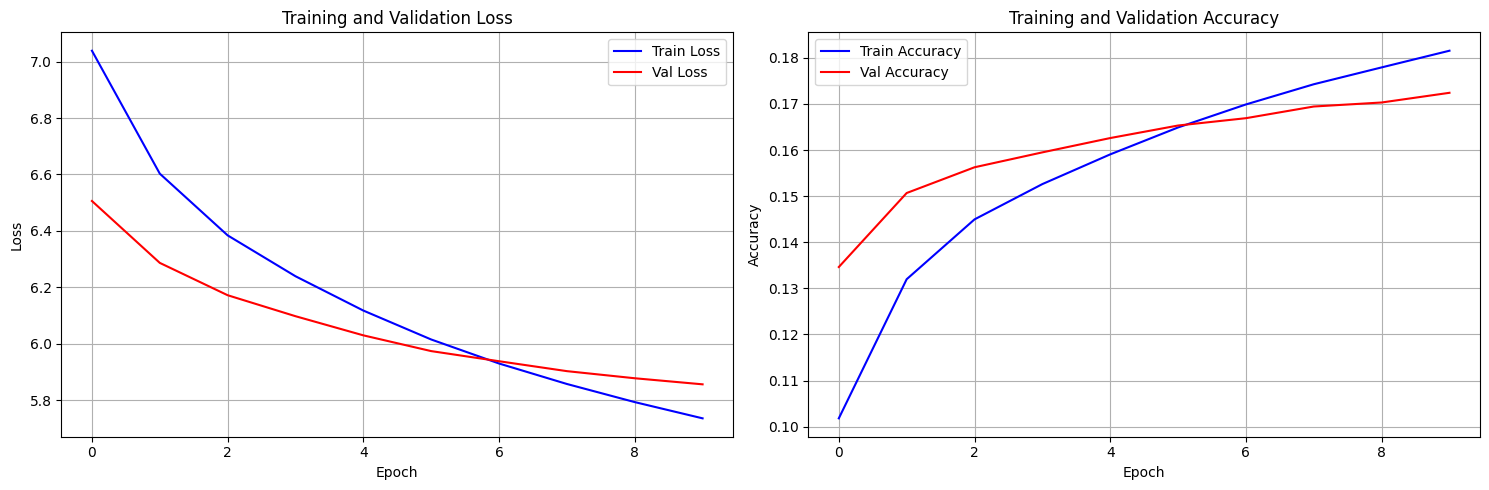


✅ Training completed!
📁 Model saved as 'gru_language_model.pth'
🎯 Final validation accuracy: 0.1724


In [7]:
# Train the GRU Language Model

# Training Loop for GRU Language Model

import torch
import torch.nn as nn
import time
from tqdm import tqdm
import matplotlib.pyplot as plt

def train_epoch(model, train_loader, criterion, optimizer, device, epoch):
    """Train the model for one epoch"""
    model.train()
    total_loss = 0
    total_samples = 0
    correct_predictions = 0
    
    # Progress bar
    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1} Training')
    
    for batch_idx, (sequences, targets) in enumerate(pbar):
        # Move data to device
        sequences = sequences.to(device)
        targets = targets.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        logits, hidden = model(sequences)
        
        # Calculate loss (predict next token from last timestep)
        last_token_logits = logits[:, -1, :]  # [batch_size, vocab_size]
        loss = criterion(last_token_logits, targets)
        
        # Backward pass
        loss.backward()
        
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        # Update weights
        optimizer.step()
        
        # Statistics
        total_loss += loss.item()
        total_samples += targets.size(0)
        
        # Calculate accuracy
        predictions = torch.argmax(last_token_logits, dim=-1)
        correct_predictions += (predictions == targets).sum().item()
        
        # Update progress bar
        avg_loss = total_loss / (batch_idx + 1)
        accuracy = correct_predictions / total_samples
        pbar.set_postfix({
            'Loss': f'{avg_loss:.4f}',
            'Acc': f'{accuracy:.4f}'
        })
        
        # Print detailed stats every 1000 batches
        if (batch_idx + 1) % 1000 == 0:
            print(f'\nBatch {batch_idx+1}/{len(train_loader)}:')
            print(f'  Loss: {avg_loss:.4f}')
            print(f'  Accuracy: {accuracy:.4f}')
    
    avg_loss = total_loss / len(train_loader)
    accuracy = correct_predictions / total_samples
    
    return avg_loss, accuracy

def validate_epoch(model, val_loader, criterion, device, epoch):
    """Validate the model"""
    model.eval()
    total_loss = 0
    total_samples = 0
    correct_predictions = 0
    
    with torch.no_grad():
        pbar = tqdm(val_loader, desc=f'Epoch {epoch+1} Validation')
        
        for sequences, targets in pbar:
            # Move data to device
            sequences = sequences.to(device)
            targets = targets.to(device)
            
            # Forward pass
            logits, hidden = model(sequences)
            
            # Calculate loss
            last_token_logits = logits[:, -1, :]
            loss = criterion(last_token_logits, targets)
            
            # Statistics
            total_loss += loss.item()
            total_samples += targets.size(0)
            
            # Calculate accuracy
            predictions = torch.argmax(last_token_logits, dim=-1)
            correct_predictions += (predictions == targets).sum().item()
            
            # Update progress bar
            avg_loss = total_loss / len(val_loader) if len(val_loader) > 0 else 0
            accuracy = correct_predictions / total_samples
            pbar.set_postfix({
                'Val Loss': f'{avg_loss:.4f}',
                'Val Acc': f'{accuracy:.4f}'
            })
    
    avg_loss = total_loss / len(val_loader)
    accuracy = correct_predictions / total_samples
    
    return avg_loss, accuracy

def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10):
    """Complete training loop"""
    
    # Training history
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    
    best_val_loss = float('inf')
    best_model_state = None
    
    print(f"Starting training for {num_epochs} epochs...")
    print(f"Training batches: {len(train_loader)}")
    print(f"Validation batches: {len(val_loader)}")
    print("-" * 60)
    
    start_time = time.time()
    
    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        
        # Training
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device, epoch)
        
        # Validation
        val_loss, val_acc = validate_epoch(model, val_loader, criterion, device, epoch)
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            print(f"✓ New best model saved! Val Loss: {val_loss:.4f}")
        
        # Record history
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        
        # Print epoch summary
        epoch_time = time.time() - epoch_start_time
        print(f"\nEpoch {epoch+1}/{num_epochs} Summary:")
        print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"  Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
        print(f"  Time: {epoch_time:.2f}s")
        print("-" * 60)
    
    total_time = time.time() - start_time
    print(f"\nTraining completed in {total_time:.2f}s")
    print(f"Best validation loss: {best_val_loss:.4f}")
    
    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print("Loaded best model weights")
    
    return {
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies,
        'best_val_loss': best_val_loss
    }

def plot_training_history(history):
    """Plot training curves"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss plot
    ax1.plot(history['train_losses'], label='Train Loss', color='blue')
    ax1.plot(history['val_losses'], label='Val Loss', color='red')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Accuracy plot
    ax2.plot(history['train_accuracies'], label='Train Accuracy', color='blue')
    ax2.plot(history['val_accuracies'], label='Val Accuracy', color='red')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

# Start training
print("🚀 Starting GRU Language Model Training...")
print(f"Model has {sum(p.numel() for p in model.parameters()):,} parameters")

# Training parameters
num_epochs = 10  # As specified in your notebook header

# Train the model
history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs
)

# Plot results
plot_training_history(history)

# Save the trained model
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'history': history,
    'vocab': vocab,
    'model_config': {
        'vocab_size': vocab_size,
        'embedding_dim': embedding_dim,
        'hidden_dim': hidden_dim,
        'num_layers': num_layers,
        'dropout': dropout
    }
}, 'gru_language_model.pth')

print("\n✅ Training completed!")
print("📁 Model saved as 'gru_language_model.pth'")
print(f"🎯 Final validation accuracy: {history['val_accuracies'][-1]:.4f}")

In [ ]:
# Test the trained model

# Text Generation and Next Word Prediction

import torch
import torch.nn.functional as F

def predict_next_word(model, input_text, vocab, idx_to_word, device, temperature=1.0, top_k=None):
    """
    Predict the next word given an input text
    
    Args:
        model: Trained GRU model
        input_text: Input sentence as string
        vocab: Vocabulary dictionary
        idx_to_word: Index to word mapping
        device: Device to run inference on
        temperature: Sampling temperature (higher = more random)
        top_k: If specified, only sample from top k most likely tokens
    
    Returns:
        predicted_word: The predicted next word
        probabilities: Top 10 word probabilities
    """
    model.eval()
    
    with torch.no_grad():
        # Tokenize input text
        tokens = basic_tokenize(input_text)
        if len(tokens) == 0:
            return "<unk>", []
        
        # Convert to indices
        indices = [vocab.get(token, vocab['<unk>']) for token in tokens]
        
        # Pad or truncate to sequence length (50)
        sequence_length = 50
        if len(indices) < sequence_length:
            # Pad with <pad> tokens at the beginning
            indices = [vocab['<pad>']] * (sequence_length - len(indices)) + indices
        else:
            # Take the last 50 tokens
            indices = indices[-sequence_length:]
        
        # Convert to tensor
        input_tensor = torch.tensor([indices], dtype=torch.long).to(device)  # [1, seq_len]
        
        # Forward pass
        logits, hidden = model(input_tensor)
        
        # Get logits for the last token
        last_logits = logits[0, -1, :]  # [vocab_size]
        
        # Apply temperature
        if temperature != 1.0:
            last_logits = last_logits / temperature
        
        # Apply top-k filtering if specified
        if top_k is not None:
            top_k = min(top_k, last_logits.size(-1))
            top_k_logits, top_k_indices = torch.topk(last_logits, top_k)
            # Set all other logits to negative infinity
            filtered_logits = torch.full_like(last_logits, float('-inf'))
            filtered_logits[top_k_indices] = top_k_logits
            last_logits = filtered_logits
        
        # Convert to probabilities
        probabilities = F.softmax(last_logits, dim=-1)
        
        # Get top 10 predictions for display
        top_probs, top_indices = torch.topk(probabilities, 10)
        top_words = [(idx_to_word[idx.item()], prob.item()) for idx, prob in zip(top_indices, top_probs)]
        
        # Sample from the distribution
        predicted_idx = torch.multinomial(probabilities, 1).item()
        predicted_word = idx_to_word[predicted_idx]
        
        return predicted_word, top_words

def generate_text(model, seed_text, vocab, idx_to_word, device, num_words=10, temperature=1.0, top_k=50):
    """
    Generate multiple words continuing from seed text
    
    Args:
        model: Trained GRU model
        seed_text: Starting text
        vocab: Vocabulary dictionary
        idx_to_word: Index to word mapping
        device: Device to run inference on
        num_words: Number of words to generate
        temperature: Sampling temperature
        top_k: Top-k sampling parameter
    
    Returns:
        generated_text: Complete generated text
    """
    model.eval()
    
    current_text = seed_text
    generated_words = []
    
    print(f"Seed text: '{seed_text}'")
    print("Generating words:")
    
    for i in range(num_words):
        predicted_word, top_words = predict_next_word(
            model, current_text, vocab, idx_to_word, device, temperature, top_k
        )
        
        # Skip special tokens
        if predicted_word in ['<unk>', '<pad>']:
            predicted_word = top_words[1][0] if len(top_words) > 1 else "the"
        
        generated_words.append(predicted_word)
        current_text += " " + predicted_word
        
        print(f"  {i+1}. {predicted_word} (top candidates: {[w[0] for w in top_words[:3]]})")
    
    generated_text = seed_text + " " + " ".join(generated_words)
    return generated_text

def interactive_prediction(model, vocab, idx_to_word, device):
    """
    Interactive mode for testing the model
    """
    print("\n🤖 Interactive Text Prediction Mode")
    print("Enter a sentence and I'll predict the next word!")
    print("Type 'quit' to exit, 'generate' to generate multiple words")
    print("-" * 60)
    
    while True:
        user_input = input("\nEnter text: ").strip()
        
        if user_input.lower() == 'quit':
            print("Goodbye! 👋")
            break
        
        if user_input.lower() == 'generate':
            seed_text = input("Enter seed text for generation: ").strip()
            if seed_text:
                num_words = int(input("How many words to generate? (default 10): ") or "10")
                temperature = float(input("Temperature (0.1-2.0, default 1.0): ") or "1.0")
                
                print(f"\n🎯 Generating {num_words} words...")
                generated = generate_text(model, seed_text, vocab, idx_to_word, device, 
                                        num_words=num_words, temperature=temperature, top_k=50)
                print(f"\n📝 Complete text: '{generated}'")
            continue
        
        if user_input:
            print(f"\n🔍 Analyzing: '{user_input}'")
            
            # Predict next word
            predicted_word, top_words = predict_next_word(
                model, user_input, vocab, idx_to_word, device, temperature=1.0, top_k=50
            )
            
            print(f"🎯 Predicted next word: '{predicted_word}'")
            print(f"\n📊 Top 10 candidates:")
            for i, (word, prob) in enumerate(top_words, 1):
                print(f"  {i:2d}. {word:<15} ({prob:.4f})")
            
            # Show the complete sentence
            complete_sentence = user_input + " " + predicted_word
            print(f"\n📝 Complete sentence: '{complete_sentence}'")

# Test the model with some examples
print("🧪 Testing the trained GRU model...")

# Example sentences to test
test_sentences = [
    "The cat sat on the",
    "I love to eat",
    "The weather today is",
    "Machine learning is",
    "In the future we will",
    "The president of the United",
    "Scientists have discovered a new",
    "The book was very"
]

print("\n📋 Testing with example sentences:")
print("=" * 60)

for i, sentence in enumerate(test_sentences, 1):
    print(f"\n{i}. Input: '{sentence}'")
    
    predicted_word, top_words = predict_next_word(
        model, sentence, vocab, idx_to_word, device, temperature=0.8, top_k=50
    )
    
    print(f"   Predicted: '{predicted_word}'")
    print(f"   Top 3: {[w[0] for w in top_words[:3]]}")
    print(f"   Complete: '{sentence} {predicted_word}'")

# Start interactive mode
interactive_prediction(model, vocab, idx_to_word, device)

🧪 Testing the trained GRU model...

📋 Testing with example sentences:

1. Input: 'The cat sat on the'
   Predicted: 'unk'
   Top 3: ['first', 'unk', 'island']
   Complete: 'The cat sat on the unk'

2. Input: 'I love to eat'
   Predicted: 'the'
   Top 3: ['the', 'a', 'unk']
   Complete: 'I love to eat the'

3. Input: 'The weather today is'
   Predicted: 'generally'
   Top 3: ['a', 'the', 'also']
   Complete: 'The weather today is generally'

4. Input: 'Machine learning is'
   Predicted: 'most'
   Top 3: ['a', 'the', 'an']
   Complete: 'Machine learning is most'

5. Input: 'In the future we will'
   Predicted: 'have'
   Top 3: ['be', 'have', 'not']
   Complete: 'In the future we will have'

6. Input: 'The president of the United'
   Predicted: 'states'
   Top 3: ['states', 'kingdom', 'nations']
   Complete: 'The president of the United states'

7. Input: 'Scientists have discovered a new'
   Predicted: 'government'
   Top 3: ['year', 'version', 'role']
   Complete: 'Scientists have disco


Enter text:  Hello, world! I am Archer. What is your



🔍 Analyzing: 'Hello, world! I am Archer. What is your'
🎯 Predicted next word: 'way'

📊 Top 10 candidates:
   1. unk             (0.3377)
   2. first           (0.1444)
   3. own             (0.0813)
   4. love            (0.0381)
   5. most            (0.0293)
   6. best            (0.0262)
   7. name            (0.0258)
   8. use             (0.0219)
   9. last            (0.0216)
  10. great           (0.0179)

📝 Complete sentence: 'Hello, world! I am Archer. What is your way'



Enter text:  He does not want to drink this



🔍 Analyzing: 'He does not want to drink this'
🎯 Predicted next word: 'time'

📊 Top 10 candidates:
   1. unk             (0.1353)
   2. with            (0.0529)
   3. to              (0.0496)
   4. as              (0.0481)
   5. in              (0.0475)
   6. work            (0.0421)
   7. use             (0.0342)
   8. other           (0.0289)
   9. name            (0.0271)
  10. time            (0.0265)

📝 Complete sentence: 'He does not want to drink this time'



Enter text:  He does not like this kind of 



🔍 Analyzing: 'He does not like this kind of'
🎯 Predicted next word: 'two'

📊 Top 10 candidates:
   1. the             (0.1570)
   2. their           (0.0626)
   3. a               (0.0570)
   4. his             (0.0422)
   5. unk             (0.0353)
   6. ireland         (0.0305)
   7. interest        (0.0260)
   8. all             (0.0240)
   9. each            (0.0233)
  10. those           (0.0233)

📝 Complete sentence: 'He does not like this kind of two'



Enter text:  Hello



🔍 Analyzing: 'Hello'
🎯 Predicted next word: 'and'

📊 Top 10 candidates:
   1. unk             (0.3862)
   2. and             (0.3561)
   3. the             (0.0491)
   4. in              (0.0238)
   5. were            (0.0133)
   6. which           (0.0103)
   7. of              (0.0087)
   8. university      (0.0077)
   9. a               (0.0076)
  10. who             (0.0076)

📝 Complete sentence: 'Hello and'



Enter text:  How are



🔍 Analyzing: 'How are'
🎯 Predicted next word: 'found'

📊 Top 10 candidates:
   1. also            (0.0793)
   2. the             (0.0764)
   3. a               (0.0539)
   4. not             (0.0448)
   5. one             (0.0417)
   6. used            (0.0397)
   7. unk             (0.0294)
   8. made            (0.0287)
   9. called          (0.0266)
  10. in              (0.0251)

📝 Complete sentence: 'How are found'



Enter text:  How are you, fine



🔍 Analyzing: 'How are you, fine'
🎯 Predicted next word: 'and'

📊 Top 10 candidates:
   1. and             (0.6350)
   2. unk             (0.1204)
   3. the             (0.0433)
   4. in              (0.0298)
   5. with            (0.0241)
   6. as              (0.0140)
   7. to              (0.0128)
   8. for             (0.0088)
   9. or              (0.0087)
  10. life            (0.0059)

📝 Complete sentence: 'How are you, fine and'



Enter text:  How are you, find and



🔍 Analyzing: 'How are you, find and'
🎯 Predicted next word: 'unk'

📊 Top 10 candidates:
   1. the             (0.1755)
   2. a               (0.0967)
   3. unk             (0.0864)
   4. that            (0.0842)
   5. as              (0.0489)
   6. their           (0.0350)
   7. by              (0.0348)
   8. in              (0.0306)
   9. for             (0.0229)
  10. to              (0.0229)

📝 Complete sentence: 'How are you, find and unk'



Enter text:  How are you, fine and



🔍 Analyzing: 'How are you, fine and'
🎯 Predicted next word: 'the'

📊 Top 10 candidates:
   1. unk             (0.3697)
   2. the             (0.2034)
   3. other           (0.0370)
   4. a               (0.0316)
   5. was             (0.0235)
   6. is              (0.0154)
   7. and             (0.0153)
   8. others          (0.0151)
   9. in              (0.0133)
  10. it              (0.0130)

📝 Complete sentence: 'How are you, fine and the'



Enter text:  How are you, find and thank



🔍 Analyzing: 'How are you, find and thank'
🎯 Predicted next word: 'when'

📊 Top 10 candidates:
   1. the             (0.1869)
   2. by              (0.1784)
   3. for             (0.0763)
   4. a               (0.0529)
   5. unk             (0.0462)
   6. and             (0.0384)
   7. in              (0.0366)
   8. as              (0.0358)
   9. to              (0.0271)
  10. that            (0.0182)

📝 Complete sentence: 'How are you, find and thank when'



Enter text:  How are you, fine and thank



🔍 Analyzing: 'How are you, fine and thank'
🎯 Predicted next word: 'richard'

📊 Top 10 candidates:
   1. by              (0.1482)
   2. the             (0.1446)
   3. unk             (0.1255)
   4. for             (0.0554)
   5. and             (0.0469)
   6. a               (0.0303)
   7. in              (0.0259)
   8. john            (0.0249)
   9. it              (0.0236)
  10. as              (0.0173)

📝 Complete sentence: 'How are you, fine and thank richard'



Enter text:  How are you, fine and thank you.



🔍 Analyzing: 'How are you, fine and thank you.'
🎯 Predicted next word: 'think'

📊 Top 10 candidates:
   1. have            (0.1389)
   2. are             (0.0899)
   3. and             (0.0662)
   4. unk             (0.0654)
   5. re              (0.0547)
   6. were            (0.0524)
   7. to              (0.0382)
   8. was             (0.0378)
   9. can             (0.0375)
  10. had             (0.0271)

📝 Complete sentence: 'How are you, fine and thank you. think'
